In [2]:
import pandas as pd
import numpy as np
import scipy.sparse as sps

c:\Users\chris\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\chris\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\chris\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
from eals import ElementwiseAlternatingLeastSquares, load_model

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from ast import literal_eval

In [5]:
import matplotlib as plt

In [1]:
%cd

C:\Users\chris


In [7]:
movies = pd.read_csv('movies_metadata.csv', low_memory = False)

In [8]:
movies = movies.loc[:, ['id', 'genres']]
movies['genres'] = (
    movies['genres']
    .fillna('[]')
    .apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
)
movies.head()

,id,genres
0,862,"[Animation, Comedy, Family]"
1,8844,"[Adventure, Fantasy, Family]"
2,15602,"[Romance, Comedy]"
3,31357,"[Comedy, Drama, Romance]"
4,11862,[Comedy]


In [9]:
genres = set([item for row in movies['genres'].values for item in row])

In [10]:
for g in genres:
    movies[g] = 0

for row in range(movies.shape[0]):
    for g in movies.loc[row, 'genres']:
        movies.at[row, g] = 1
    
movies.head()

,id,genres,Animation,Odyssey Media,Rogue State,Western,Adventure,War,Sentai Filmworks,The Cartel,...,Comedy,Romance,BROSTA TV,Foreign,Family,Music,Carousel Productions,Science Fiction,Action,Pulser Productions
0,862,"[Animation, Comedy, Family]",1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,8844,"[Adventure, Fantasy, Family]",0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,15602,"[Romance, Comedy]",0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,31357,"[Comedy, Drama, Romance]",0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
4,11862,[Comedy],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [11]:
movies['genres_bitmap'] = movies.iloc[:, 2:].apply(lambda row : ''.join([str(x) for x in row]), axis = 1)
counts = movies['genres_bitmap'].value_counts()

counts = pd.DataFrame({
    'genres_bitmap' : counts.index,
    'genres_counts' : counts
})

# leave only the popular combinations of genres
counts = counts.loc[counts['genres_counts'] >= 10, :]
counts.shape

(359, 2)

In [12]:
movies = movies.merge(counts, on = 'genres_bitmap', how = 'inner')
movies.rename(columns = {'movie id' : 'movie_id'}, inplace = True)
movies['genreId'] = movies['genres_bitmap'].astype("category").cat.codes
movies['movieId'] = movies['id'].astype('int64')

movies.head()

,id,genres,Animation,Odyssey Media,Rogue State,Western,Adventure,War,Sentai Filmworks,The Cartel,...,Family,Music,Carousel Productions,Science Fiction,Action,Pulser Productions,genres_bitmap,genres_counts,genreId,movieId
0,862,"[Animation, Comedy, Family]",1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,10000000000000000000001000100000,112,338,862
1,12233,"[Animation, Comedy, Family]",1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,10000000000000000000001000100000,112,338,12233
2,532,"[Family, Animation, Comedy]",1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,10000000000000000000001000100000,112,338,532
3,531,"[Animation, Comedy, Family]",1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,10000000000000000000001000100000,112,338,531
4,40688,"[Animation, Comedy, Family]",1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,10000000000000000000001000100000,112,338,40688


In [13]:
ratings = pd.read_csv('ratings_small.csv', low_memory=False)

In [14]:
ratings_genres = (
    ratings.loc[:, ['userId', 'movieId', 'rating']]
    .merge(movies.loc[:, ['movieId', 'genreId']], on = 'movieId', how = 'inner')
)

ratings_genres.head()

,userId,movieId,rating,genreId
0,1,1371,2.5,50
1,4,1371,4.0,50
2,7,1371,3.0,50
3,19,1371,4.0,50
4,21,1371,3.0,50


In [15]:
ratings_counts = (
    ratings_genres.groupby(['userId', 'genreId'], as_index = False)['movieId'].count()
    .rename(columns = {'movieId' : 'counts'})
)

ratings_counts.head()

,userId,genreId,counts
0,1,13,1
1,1,24,1
2,1,50,1
3,1,70,1
4,1,89,1


In [16]:
# sanity check
(
    ratings_genres
    .merge(ratings_counts, on = ['userId', 'genreId'], how = 'left')
    .sort_values(by = ['userId', 'genreId'])
).head(20)

,userId,movieId,rating,genreId,counts
182,1,2294,2.0,13,1
93,1,2105,4.0,24,1
0,1,1371,2.5,50,1
140,1,2193,2.0,70,1
47,1,1405,1.0,89,1
235,1,2455,2.5,207,1
2619,2,349,4.0,13,1
2017,2,296,4.0,33,1
1366,2,222,5.0,49,1
822,2,153,4.0,50,7


In [17]:
(
    ratings_genres
    .merge(ratings_counts, on = ['userId', 'genreId'], how = 'left')
    .loc[:, ['rating', 'counts']]
).corr()

,rating,counts
rating,1.000000,-0.066247
counts,-0.066247,1.000000


AttributeError: module 'matplotlib' has no attribute 'show'

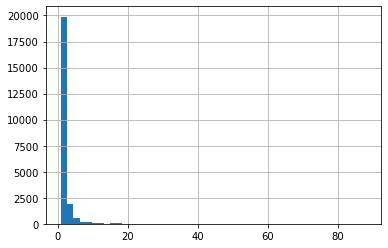

In [18]:
ratings_counts['counts'].hist(bins = 50)
plt.show()

In [19]:
ratings_counts.dropna(axis = 0, inplace = True)
ratings.dropna(axis = 0, inplace = True)

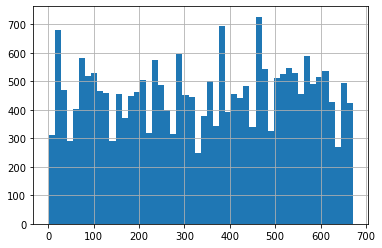

In [20]:
ratings_counts.userId.hist(bins=50)

In [55]:
#only take users with at least x item interactions
grouped_full = ratings_counts.groupby(['userId'])['genreId'].count().reset_index()
min20full = grouped_full[grouped_full.genreId > 10]
ratings_counts_minu = ratings_counts[ratings_counts.userId.isin(min20full.userId)]

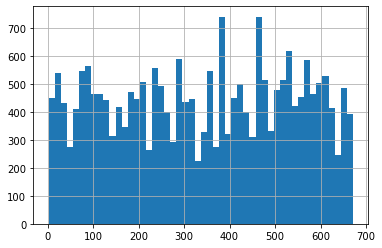

In [56]:
ratings_counts_minu.userId.hist(bins=50)

In [57]:
ratings_counts_train, ratings_counts_test = train_test_split(ratings_counts_minu, test_size = 0.2, random_state = 42)

In [58]:
ratings_counts_train_sparse = sps.csr_matrix((ratings_counts_train['counts'], (ratings_counts_train['userId'], ratings_counts_train['genreId'])), dtype=np.float32)

In [59]:
model = ElementwiseAlternatingLeastSquares(factors=100, alpha=0.5, regularization=0.01, w0=0.002)
model

In [60]:
model.fit(ratings_counts_train_sparse)

In [63]:
user_list = ratings_counts_test.userId
test_mpr = get_MPR(user_list)
test_mpr

0.4206324569991457

In [80]:
def get_MPR(users, model) :
    zähler = 0
    nenner = 0
    for u in users :
        predictions = get_rec_list(u, model)
        counts = get_counts(u)
        df = pd.DataFrame({'predictions': predictions, 'counts' : counts})
        df = df.sort_values('predictions', ascending=False)
        df['rank'] = get_rank(u)
        for i in range(len(df)) :
            zähler += df['counts'].iloc[i] * df['rank'].iloc[i]
            nenner += df['counts'].iloc[i] 
    return zähler / nenner

In [81]:
# helperfunc for get_mpr
def get_rec_list(user, model) :
    items = ratings_counts_test[ratings_counts_test.userId == user].genreId.unique()
    ratings = []
    for i in items :
        pred = np.inner(model.user_factors[user], model.item_factors[i])
        ratings.append(pred)
    return ratings

In [29]:
# helperfunc for get_mpr
def get_rank(user) :
    no_of_items = ratings_counts_test[ratings_counts_test.userId == user].genreId.nunique()
    percentlile_rank = [] 
    for i in range(no_of_items) :
        percentlile_rank.append((i+1) / no_of_items)
    return percentlile_rank

In [30]:
# helperfunc for get_mpr
def get_counts(user) :
    no_of_items = ratings_counts_test[ratings_counts_test.userId == user].counts
    return no_of_items

In [35]:
rmse_test = evaluate(ratings_counts_test, 'mae')
rmse_test

In [194]:
def evaluate(test_df, metric) :
    squared_diff = 0
    abs_diff = 0
    num_obs = 0
    for i in test_df.index:
        r = test_df.counts[i]
        user_id = test_df.userId[i]
        item_id = test_df.genreId[i]
        r_hat = np.inner(model.user_factors[user_id], model.item_factors[item_id])
        squared_diff += (r - r_hat) ** 2
        abs_diff += abs(r - r_hat)
        num_obs += 1
    if metric == 'rmse' :
        return np.sqrt(squared_diff / num_obs)
    if metric == 'mse' :
        return squared_diff / num_obs
    if metric == 'mae' :
        return abs_diff / num_obs
    

In [188]:
def evaluate(test_df, rating_col, user_col, item_col, metric) :
    squared_diff = 0
    abs_diff = 0
    num_obs = 0
    for i in test_df.index:
        r = test_df[rating_col].iloc[i]
        user_id = test_df[user_col].iloc[i]
        item_id = test_df[item_col].iloc[i]
        r_hat = np.inner(model.user_factors[user_id], model.item_factors[item_id])
        squared_diff += (r - r_hat) ** 2
        abs_diff += abs(r - r_hat)
        num_obs += 1
    if metric == 'rmse' :
        return np.sqrt(squared_diff / num_obs)
    if metric == 'mse' :
        return squared_diff / num_obs
    if metric == 'mae' :
        return abs_diff / num_obs
    


In [2]:
from implicit.evaluation import AUC_at_k

In [6]:
!pip install --upgrade implicit

Requirement already up-to-date: implicit in c:\users\chris\anaconda3\lib\site-packages (0.5.2)


In [7]:
import implicit

In [9]:
model_ials = implicit.als.AlternatingLeastSquares(factors=100, regularization=10, iterations=30)

In [10]:
ratings_counts_train_coo = ratings_counts_train_sparse.tocoo()

NameError: name 'ratings_counts_train_sparse' is not defined

In [94]:
model_ials.fit(ratings_counts_train_coo)

100%|██████████| 30/30 [00:00<00:00, 46.14it/s]


In [95]:
user_list = ratings_counts_test.userId
test_mpr = get_MPR(user_list, model_ials)
test_mpr

0.4174168437641856